In [1]:
import os
import json
from pprint import pprint
from copy import deepcopy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from subprocess import check_output

## **Load all json and convert to dataframe**

In [ ]:
# this part use functions from kernel CORD-19-EDA,parse JSON and generate clean csv
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    
    for file in tqdm(all_files):
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]

        cleaned_files.append(features)

    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text', 
                 'bibliography','raw_authors','raw_bibliography']

    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df.head()
    
    return clean_df

In [ ]:
biorxiv_dir = '/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

In [ ]:
all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)
file = all_files[0]
print("Dictionary keys:", file.keys())

In [ ]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)
len(cleaned_files)

In [ ]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head(5)

In [ ]:
#clean_df.to_csv('biorxiv_clean.csv', index=False)
pmc_dir = '/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pdf_json/'
pmc_files = load_files(pmc_dir)
pmc_df = generate_clean_df(pmc_files)
#pmc_df.to_csv('clean_pmc.csv', index=False)
#pmc_df.head()
comm_dir = '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/'
comm_files = load_files(comm_dir)
comm_df = generate_clean_df(comm_files)
#comm_df.to_csv('clean_comm_use.csv', index=False)
#comm_df.head()
noncomm_dir = '/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json/'
noncomm_files = load_files(noncomm_dir)
noncomm_df = generate_clean_df(noncomm_files)
#noncomm_df.to_csv('clean_noncomm_use.csv', index=False)
#noncomm_df.head()


In [ ]:
#check the number of json files from each directory
print(len(clean_df))
print(len(pmc_df))
print(len(comm_df))
print(len(noncomm_df))

In [ ]:
bigdata1 = pd.concat([clean_df, pmc_df], ignore_index=True, sort =False)
bigdata2 = pd.concat([comm_df, noncomm_df], ignore_index=True, sort =False)
final_df = pd.concat([bigdata1, bigdata2], ignore_index=True, sort =False)
print(len(final_df))
#final_df.to_csv('alljson.csv', index=False)
del clean_df,pmc_df,comm_df,noncomm_df,bigdata1,bigdata2

In [ ]:
final_df.columns

In [ ]:
final_df['paper_id'][:5]

## **Loading the metadata**

In [2]:
meta_df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv') # 
nRow, nCol = meta_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 47298 rows and 18 columns


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
meta_df.head(5)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,8q5ondtn,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(72)90077-4
1,pzfd0e50,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90355-5
2,22bka3gi,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90356-7
3,zp9k1k3z,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/0002-9343(73)90176-9
4,cjuzul89,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-9343(85)90361-4


In [4]:
meta_df.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url'],
      dtype='object')

In [5]:
meta_df['sha'].isna().sum() 

13015

In [6]:
meta_df1=meta_df[meta_df['sha'].notnull()]
print(len(meta_df1))

34283


## Merge two dataframes, metadata and all json text

In [ ]:
# finding out how many paper id from json overlaps with metadata sha, so we can merge them together
print(len(list(set(meta_df1['sha'])&set(final_df['paper_id']))))

In [ ]:
#merge two dataframes
pd_merge_all= pd.merge(meta_df1, final_df, how='inner',left_on='sha', right_on='paper_id')
print(len(pd_merge_all))

In [ ]:
# remove some duplicate columns
pd_merge_all=pd_merge_all[['cord_uid', 'sha', 'source_x', 'title_x', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract_x', 'publish_time', 'authors_x', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url', 'affiliations', 'text', 'bibliography',
       'raw_authors', 'raw_bibliography']]

In [ ]:
pd_merge_all=pd_merge_all.dropna(subset=['sha', 'text'])  # drop if any of these two columns have nan

## ** NLP processing **

In [7]:
import re
import nltk
import string

In [ ]:
# remove nan titles
print(len(pd_merge_all))
pd_merge_all=pd_merge_all[pd_merge_all['title_x']!='nan']
print(len(pd_merge_all))

In [ ]:
# remove nan abstracts
print(len(pd_merge_all))
pd_merge_all=pd_merge_all[pd_merge_all['abstract_x']!='nan']
print(len(pd_merge_all))

  ## Normalization of text
The following was only done to metadata abstract text, it can be easily done to alljson dataframe text column, but due to memory limit, only show the process to abstract 

In [11]:
# data cleaning
def clean_dfonecol(new_df,col):
    new_df=new_df.replace(np.nan,'',regex = True)
    new_df = new_df[pd.notnull(new_df[col])] 
    #print(len(new_df))
    # lower case
    new_df[col] = new_df[col].apply(lambda x: x.lower()) 
    #punctuation
    new_df[col] = new_df[col].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    return new_df


#pd_merge_all=clean_dfonecol(pd_merge_all,'title_x')
#print(len(pd_merge_all))
#pd_merge_all=clean_dfonecol(pd_merge_all,'abstract_x')
#print(len(pd_merge_all))
#pd_merge_all=clean_dfonecol(pd_merge_all,'text')    # too much text to process
#print(len(pd_merge_all))

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
    
def remv_stopwords(new_df,col):
# remove stopwords
    
    new_df[col]= new_df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    new_df[col]= new_df[col].str.findall('\w{2,}').str.join(' ')
    return new_df

#pd_merge_all=remv_stopwords(pd_merge_all,'abstract_x')
#pd_merge_all=remv_stopwords(pd_merge_all,'text') # takes too much memory, so not runnning it

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


##### Since text column will take a lot of memory, will only perform on abstract for now

In [43]:
# only process abstract from meta_df1
#print(len(meta_df1))
meta_df1=clean_dfonecol(meta_df,'abstract')
print(len(meta_df1))

47298


In [44]:
#print(len(meta_df1))
meta_df1=remv_stopwords(meta_df1,'abstract')
print(len(meta_df1))

47298


In [45]:
meta_df1.reset_index(inplace=True)

### Text processing

In [70]:
text1=[]
for i in range(len(meta_df1)):
    text1.append(meta_df1['abstract'].loc[i])
text2=[]  
for i in range(len(meta_df1)):
    text2.append(meta_df1['abstract'].loc[i].split())

In [72]:
import gensim
from gensim import corpora
from pprint import pprint
# Create dictionary
dictionary = corpora.Dictionary(text2)

In [73]:
# Get information about the dictionary
print(dictionary)

Dictionary(161350 unique tokens: ['abnormal', 'abstract', 'addition', 'agent', 'agents']...)


In [85]:
print(dictionary.token2id)

{'abnormal': 0, 'abstract': 1, 'addition': 2, 'agent': 3, 'agents': 4, 'allow': 5, 'although': 6, 'andor': 7, 'animal': 8, 'antiviral': 9, 'appear': 10, 'areas': 11, 'association': 12, 'associations': 13, 'b3': 14, 'b4': 15, 'basis': 16, 'birth': 17, 'candidates': 18, 'cardiac': 19, 'cardiovascular': 20, 'cases': 21, 'causative': 22, 'cell': 23, 'cells': 24, 'certain': 25, 'chemotherapy': 26, 'chromosomes': 27, 'conclusive': 28, 'congenital': 29, 'considered': 30, 'control': 31, 'coxsackie': 32, 'current': 33, 'damage': 34, 'damaged': 35, 'decreased': 36, 'defect': 37, 'defects': 38, 'depend': 39, 'developing': 40, 'development': 41, 'disease': 42, 'disturbed': 43, 'dna': 44, 'early': 45, 'efe': 46, 'effective': 47, 'effects': 48, 'endocardial': 49, 'endothelial': 50, 'epidemiology': 51, 'etiologic': 52, 'etiologically': 53, 'even': 54, 'evidence': 55, 'experimental': 56, 'fetus': 57, 'fibroelastosis': 58, 'focal': 59, 'future': 60, 'gained': 61, 'gestation': 62, 'growth': 63, 'heart':

In [87]:
# Create the Corpus
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in text2]
pprint(mycorpus[:10])   # this will show the token and its frequency in the text 

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 8),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 1),
  (41, 3),
  (42, 6),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 7),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 2),
  (72, 1),
  (73, 2),
  (74, 2),
  (75, 2),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 2),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

In [88]:
word_counts = [[(mydict[id], count) for id, count in line] for line in mycorpus]
pprint(word_counts)


[[('abnormal', 1),
  ('abstract', 1),
  ('addition', 1),
  ('agent', 1),
  ('agents', 1),
  ('allow', 1),
  ('although', 2),
  ('andor', 1),
  ('animal', 1),
  ('antiviral', 1),
  ('appear', 1),
  ('areas', 1),
  ('association', 2),
  ('associations', 1),
  ('b3', 1),
  ('b4', 1),
  ('basis', 1),
  ('birth', 1),
  ('candidates', 1),
  ('cardiac', 1),
  ('cardiovascular', 1),
  ('cases', 1),
  ('causative', 1),
  ('cell', 1),
  ('cells', 2),
  ('certain', 1),
  ('chemotherapy', 1),
  ('chromosomes', 1),
  ('conclusive', 1),
  ('congenital', 8),
  ('considered', 1),
  ('control', 1),
  ('coxsackie', 1),
  ('current', 1),
  ('damage', 1),
  ('damaged', 1),
  ('decreased', 1),
  ('defect', 1),
  ('defects', 2),
  ('depend', 1),
  ('developing', 1),
  ('development', 3),
  ('disease', 6),
  ('disturbed', 1),
  ('dna', 1),
  ('early', 1),
  ('efe', 1),
  ('effective', 1),
  ('effects', 1),
  ('endocardial', 1),
  ('endothelial', 1),
  ('epidemiology', 1),
  ('etiologic', 2),
  ('etiologicall

In [89]:
import gensim.downloader as api

In [ ]:
dataset = api.load("text8")

In [74]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

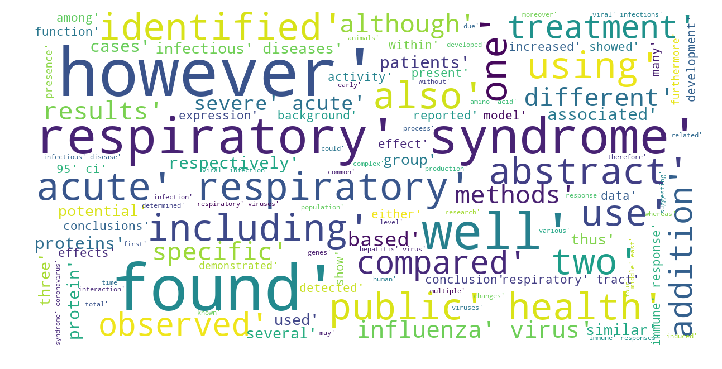

In [75]:
show_wordcloud(text2)

In [76]:
# Use gensim summarization 
from gensim.summarization import summarize, keywords
#from pprint import pprint

In [79]:
# Important keywords from the paragraph
print(keywords(text1[0]))

congenital
developing
development
viruses
infections
infection
infected
investigation
disease
results investigations
result
defects
defect
etiologic
etiologically
cells
cell damage resulting
suggests
suggestive
associations
information
association intrauterine rubella
effective
damaged
effects virus
infants
infant
study
studies
agents
agent
replication


In [84]:
# Summarize the paragraph
#pprint(summarize(text1[100], word_count=20)) # this will be good for full text summarize

#### It shows that it has 161350 unique tokens

In [51]:
#from gensim.utils import simple_preprocess
#from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
# tockenize abstract
meta_df_tokens = meta_df1.abstract.fillna('').apply(preprocess_string) 

In [49]:
meta_df_tokens[100]

'abstract nephritis chickens caused infectious bronchitis virus ibv studied virological histological electron microscopical methods strain virus caused mild respiratory signs rhode island red rir white leghorn wl breeds 50 per cent mortality induced due acute nephritis infected birds developed high titres antibody ibv 30 weeks spite persistence antibody 35 per cent rir developed chronic progressive nephritis histology showed varying degrees pathological changes tubules relatively unaffected glomeruli foci mononuclear cell infiltration prominent cortex medulla particularly chronic nephritis cytoplasmic ibv immunofluorescence found segments tubules glomeruli evidence virus replication caecal tonsil bursa fabricius evidence extensive coronavirus replication found cells tubules large number viral inclusion bodies seen containing dark smooth particles 120 nm diameter within single membrane virus readily recovered kidneys well faeces birds acute chronic nephritis concluded direct virusinduce

## **Search Use BM25**

In [15]:
#from rank_bm25 import BM25Okapi

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
# tockenize abstract
meta_df_tokens = meta_df1.abstract.fillna('').apply(preprocess_string) 

# tockenize abstract
#pd_merge_abstract_tokens = pd_merge_all.abstract_x.fillna('').apply(preprocess_string)  # tokenize each abstract to word
# tockenize the text
#pd_merge_text_tokens = pd_merge_all.text.fillna('').apply(preprocess_string)  # tokenize each textto word

In [16]:
meta_df_tokens[:100]

3      [abstract, middleag, femal, ident, twin, syste...
5      [abstract, understand, pathogenesi, infecti, e...
6      [abstract, pathogenesi, rheumatoid, arthriti, ...
7      [abstract, pharyng, bronchiti, pneumonia, repr...
8      [abstract, acut, bronchiti, ill, frequent, enc...
                             ...                        
128    [abstract, method, check, antivir, activ, mono...
129    [abstract, develop, oral, vaccin, continu, ris...
130    [abstract, replic, cycl, granulosi, viru, cydi...
131                                                   []
132    [abstract, carbohydr, content, coronaviru, gly...
Name: abstract, Length: 100, dtype: object

In [29]:
from nltk.corpus import wordnet
def find_syn_ant(word):
    synonyms = []
    antonyms = []

    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
            if l.antonyms():
                antonyms.append(l.antonyms()[0].name())

    #print(set(synonyms))
    #print(set(antonyms))
    return set(synonyms)

print(find_syn_ant("smoking"))

{'smoke', 'fume', 'smoking'}


Create a BM25Okapi index from the tokens. Implement a search function that returns the top 10 results from the search. Note that in search wer are asking the index to return the dataframe indexes of the tokens most similar to the search string.

In [14]:
!pip install rank_bm25   # don't know why it cannot be installed now

ERROR: Could not find a version that satisfies the requirement rank_bm25 (from versions: none)
ERROR: No matching distribution found for rank_bm25


In [ ]:
from rank_bm25 import BM25Okapi

In [ ]:
bm25_index = BM25Okapi(meta_df_tokens.tolist())

def search(search_string, num_results=10):  # can change the num_results to top 50 or more
    search_tokens = preprocess_string(search_string)
    scores = bm25_index.get_scores(search_tokens)
    top_indexes = np.argsort(scores)[::-1][:num_results]
    return top_indexes

In [ ]:
# now show the abstract of the top index
meta_df.loc[search('novel coronavirus treatment')][['abstract', 'publish_time']]

Check various risk factors:

- Data on potential risks factors
        - Smoking, pre-existing pulmonary disease
        - Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
        - Neonates and pregnant women
        - Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.
- Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
- Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
- Susceptibility of populations
- Public health mitigation measures that could be effective for control

In [ ]:
meta_df.loc[search('Smoking')][['abstract', 'publish_time']]